# Ironhack Final Bootcamp Project - Spaceship Titanic (Kaggle)

This project is based on the Kaggle Spaceship Titanic competition. It consists on a binary classification machine learning model, wich has the objective to predict the if a whether a person will be transported to an alternate dimension or not.

## Machine Learning Development

###  Importing libraries and quick overview on dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

In [2]:
train_data = pd.read_csv('../data/train_transformed.csv')
test_data = pd.read_csv('../data/test_transformed.csv')
submission_sample = pd.read_csv('../data/sample_submission.csv')

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerNumber,GroupSize,CabinDeck,CabinSide,GroupNumberBuckets,CabinNumberBuckets
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,B,P,Bucket 0,Bucket 0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1,F,S,Bucket 0,Bucket 0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,2 or 3,A,S,Bucket 0,Bucket 0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2 or 3,2 or 3,A,S,Bucket 0,Bucket 0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1,F,S,Bucket 0,Bucket 0


In [4]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PassengerNumber,GroupSize,CabinDeck,CabinSide,GroupNumberBuckets,CabinNumberBuckets
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1,1,G,S,Bucket 0,Bucket 0
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,1,1,F,S,Bucket 0,Bucket 0
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1,1,C,S,Bucket 0,Bucket 0
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,1,1,C,S,Bucket 0,Bucket 0
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1,1,F,S,Bucket 0,Bucket 0


Here you can see the description of each column:

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- PassengerNumber - Tells the number of the passenger within the group his travelling with.
- GroupSize - How many passengers has the group this passenger is travelling
- CabinDeck - Wich deck in the spaceship the cabin of this passenger belongs.
- CabinSide - Wich side in the spaceship the cabin of this passenger belongs.
- GroupNumberBuckets - Each group has a unique number. These numbers are bucketed in 8 different labels.
- CabinNumberBuckets - Each cabin has a number that identifies it inside it's deck and side of the spaceship. These numbers are bucketed in 6 different labels.

In [5]:
print('train_data shape',train_data.shape)
print('test_data shape', test_data.shape)

# the test_data has one less column, wich is target column i need to predict

train_data shape (8693, 19)
test_data shape (4277, 18)


In [6]:
train_data.info()
# there are some nulls, i'll need to take a look at each collumn in specific to choose the best strategy to deal with it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         8693 non-null   object 
 1   HomePlanet          8492 non-null   object 
 2   CryoSleep           8476 non-null   object 
 3   Destination         8511 non-null   object 
 4   Age                 8514 non-null   float64
 5   VIP                 8490 non-null   object 
 6   RoomService         8512 non-null   float64
 7   FoodCourt           8510 non-null   float64
 8   ShoppingMall        8485 non-null   float64
 9   Spa                 8510 non-null   float64
 10  VRDeck              8505 non-null   float64
 11  Name                8493 non-null   object 
 12  Transported         8693 non-null   bool   
 13  PassengerNumber     8693 non-null   object 
 14  GroupSize           8693 non-null   object 
 15  CabinDeck           8494 non-null   object 
 16  CabinS

In [7]:
# target column is being treated as bool. i'll treat it as an object type

train_data['Transported'] = train_data['Transported'].replace({True: 'True', False: 'False'})

In [8]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Filling Nulls

In [9]:
# Splitting both train and test sets into numericals and categorical features

# Train Set

num_feat_train = train_data.select_dtypes(np.number)
num_feat_train_cols = num_feat_train.columns # saving column names to use them later

# Columns PassengerId and Name will not be used to train the machine learning model, so they will be droped
# Column Transported is the target, so this will be droped since it's here by mistake
cat_feat_train = train_data.select_dtypes(np.object).drop(['PassengerId', 'Name', 'Transported'], axis=1)
cat_feat_train_cols = cat_feat_train.columns # saving column names to use them later

# Train Target
train_target = train_data['Transported']

# Test Set

num_feat_test = test_data.select_dtypes(np.number)
num_feat_test_cols = num_feat_test.columns # saving column names to use them later

# Columns PassengerId and Name will not be used to train the machine learning model, so they will be droped
cat_feat_test = test_data.select_dtypes(np.object).drop(['PassengerId', 'Name'], axis=1)
cat_feat_test_cols = cat_feat_test.columns # saving column names to use them later

In [10]:
# Defining different objects of SimpleImputer to use them separately on train and test sets, but with the same strategy

num_si_train = SimpleImputer(strategy='mean')
cat_si_train = SimpleImputer(strategy='most_frequent')

num_si_test = SimpleImputer(strategy='mean')
cat_si_test = SimpleImputer(strategy='most_frequent')

In [11]:
print('Percentage of nulls in Train Data', '\n',train_data.isna().sum()/len(train_data) * 100,'\n')
print('Percentage of nulls in Test Data', '\n',test_data.isna().sum()/len(test_data) * 100)

Percentage of nulls in Train Data 
 PassengerId           0.000000
HomePlanet            2.312205
CryoSleep             2.496261
Destination           2.093639
Age                   2.059128
VIP                   2.335212
RoomService           2.082135
FoodCourt             2.105142
ShoppingMall          2.392730
Spa                   2.105142
VRDeck                2.162660
Name                  2.300702
Transported           0.000000
PassengerNumber       0.000000
GroupSize             0.000000
CabinDeck             2.289198
CabinSide             2.289198
GroupNumberBuckets    0.000000
CabinNumberBuckets    2.289198
dtype: float64 

Percentage of nulls in Test Data 
 PassengerId           0.000000
HomePlanet            2.034136
CryoSleep             2.174421
Destination           2.151040
Age                   2.127660
VIP                   2.174421
RoomService           1.917232
FoodCourt             2.478373
ShoppingMall          2.291326
Spa                   2.361468
VRDeck       

In [12]:
# filling nulls on train set
num_feat_train = pd.DataFrame(num_si_train.fit_transform(num_feat_train), columns=num_feat_train_cols)
cat_feat_train = pd.DataFrame(cat_si_train.fit_transform(cat_feat_train), columns=cat_feat_train_cols)

# filling nulls on test set
num_feat_test = pd.DataFrame(num_si_test.fit_transform(num_feat_test), columns=num_feat_test_cols)
cat_feat_test = pd.DataFrame(cat_si_test.fit_transform(cat_feat_test), columns=cat_feat_test_cols)

# concatenating numerical and categorical features back together
train_data = pd.concat([num_feat_train, cat_feat_train, train_target], axis=1)
test_data = pd.concat([num_feat_test, cat_feat_test], axis=1)

In [13]:
print('Percentage of nulls in Train Data', '\n',train_data.isna().sum()/len(train_data) * 100,'\n')
print('Percentage of nulls in Test Data', '\n',test_data.isna().sum()/len(test_data) * 100)

Percentage of nulls in Train Data 
 Age                   0.0
RoomService           0.0
FoodCourt             0.0
ShoppingMall          0.0
Spa                   0.0
VRDeck                0.0
HomePlanet            0.0
CryoSleep             0.0
Destination           0.0
VIP                   0.0
PassengerNumber       0.0
GroupSize             0.0
CabinDeck             0.0
CabinSide             0.0
GroupNumberBuckets    0.0
CabinNumberBuckets    0.0
Transported           0.0
dtype: float64 

Percentage of nulls in Test Data 
 Age                   0.0
RoomService           0.0
FoodCourt             0.0
ShoppingMall          0.0
Spa                   0.0
VRDeck                0.0
HomePlanet            0.0
CryoSleep             0.0
Destination           0.0
VIP                   0.0
PassengerNumber       0.0
GroupSize             0.0
CabinDeck             0.0
CabinSide             0.0
GroupNumberBuckets    0.0
CabinNumberBuckets    0.0
dtype: float64


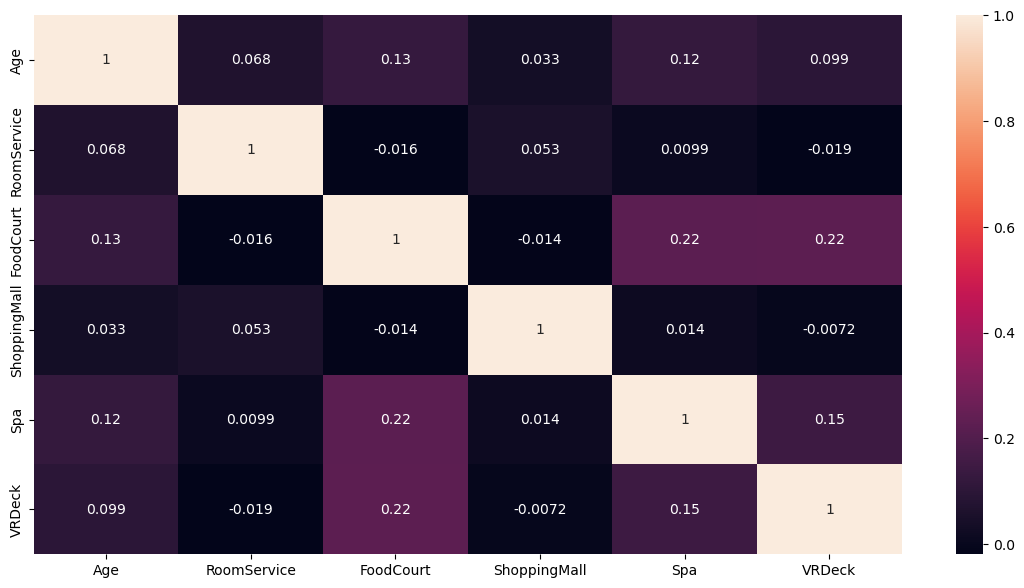

In [14]:
plt.figure(figsize=(14,7))
sns.heatmap(num_feat_train.corr(), annot=True)
plt.show()

In [15]:
for i in range(num_feat_train.shape[1]):
    print('VIF for column', num_feat_train.columns[i], '=', variance_inflation_factor(num_feat_train, i))

VIF for column Age = 1.3838864528404007
VIF for column RoomService = 1.1168200850984522
VIF for column FoodCourt = 1.1951967929570602
VIF for column ShoppingMall = 1.0792426203893426
VIF for column Spa = 1.153295408454935
VIF for column VRDeck = 1.1456372516555846


In [16]:
# All numerical features have a good VIF. I'll will not drop any of these columns

Age


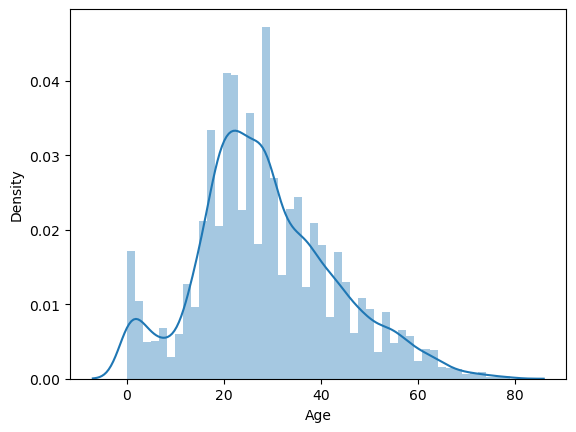

RoomService


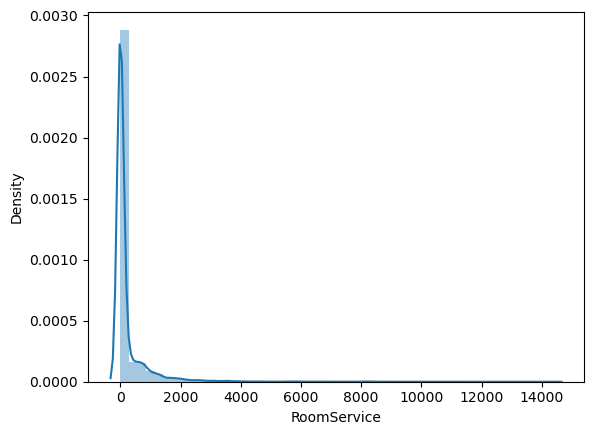

FoodCourt


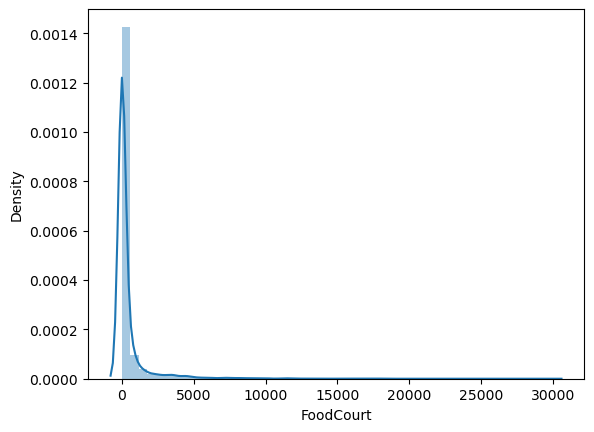

ShoppingMall


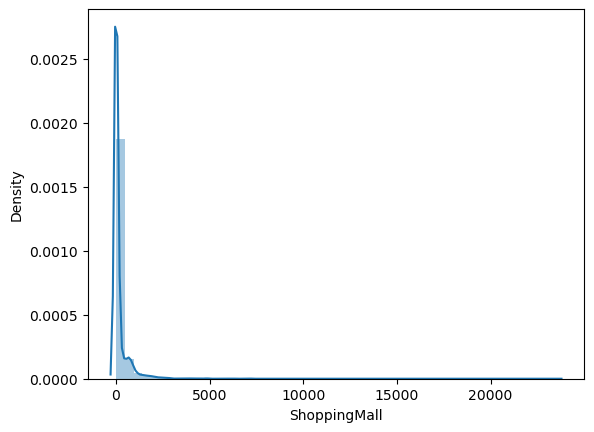

Spa


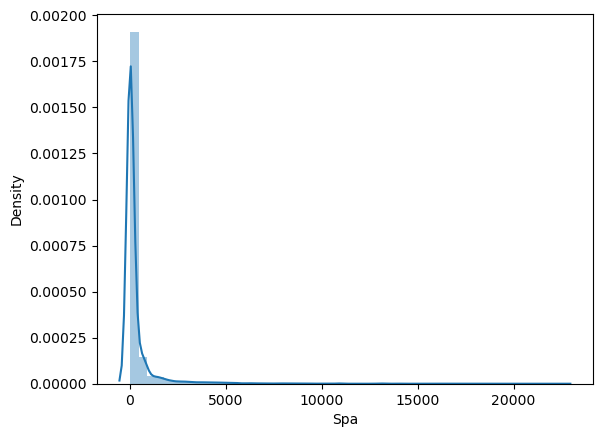

VRDeck


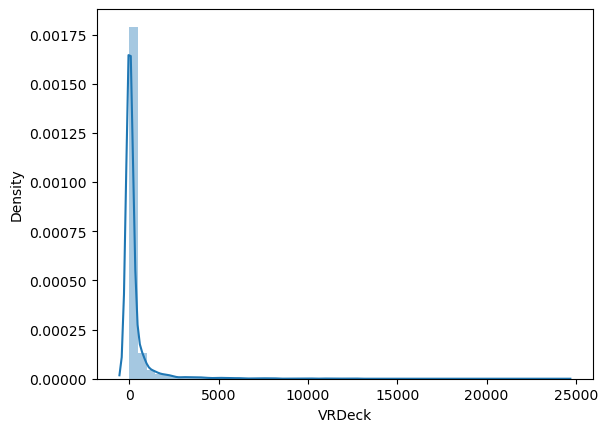

In [17]:
for col in num_feat_train.columns:
    print(col)
    sns.distplot(num_feat_train[col])
    plt.show()

In [18]:
#def log_transf(x):
#    if x > 0:
#        return np.log10(x)
#    else:
#        return np.log(x+1)
    
#for col in num_feat.drop('Age', axis=1).columns: # for loop to use the log transf on the skewed columns
#    num_feat[col] = list(map(log_transf, num_feat[col]))
#    print(col)
#    sns.distplot(num_feat[col])
#    plt.show()

# using log transformation to reduce the skewness of the numerical columns didn't help to improve the accuracy of the model

In [20]:
# just trying a quick logistic regression model to see what result i get

encoder = pd.get_dummies(cat_feat_train, drop_first=True)
scaler = Normalizer().fit_transform(num_feat_train)
scaler = pd.DataFrame(scaler, columns=num_feat_train.columns)


features = pd.concat([encoder, scaler], axis=1)
target = train_data['Transported']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

predictions = log_reg.predict(X_test)
log_reg.score(X_test, y_test)

0.780411293133496

In [21]:
# trying RFE
classification_score = []
features_used = []

lr = LogisticRegression()

for i in np.arange(24):
    selector = RFE(estimator=lr, n_features_to_select=i+1)
    X_new = selector.fit_transform(X_train, y_train)
    feature_names_out = selector.get_feature_names_out()
    
    features_used.append(feature_names_out)
    
    log_reg = LogisticRegression()
    log_reg.fit(X_new, y_train)

    classification_score.append(log_reg.score(X_test[feature_names_out], y_test))
    
max_clf_ind = classification_score.index(max(classification_score))
    
print('Max classification score using RFE:',classification_score[max_clf_ind])
print('Columns used for this score:', features_used[max_clf_ind])
print('Number of columns used:', len(features_used[max_clf_ind]))

Max classification score using RFE: 0.780411293133496
Columns used for this score: ['HomePlanet_Europa' 'HomePlanet_Mars' 'CryoSleep_True'
 'Destination_PSO J318.5-22' 'Destination_TRAPPIST-1e' 'VIP_True'
 'PassengerNumber_2 or 3' 'CabinDeck_B' 'CabinDeck_C' 'CabinDeck_D'
 'CabinDeck_E' 'CabinDeck_G' 'CabinDeck_T' 'CabinSide_S'
 'GroupNumberBuckets_Bucket 1' 'GroupNumberBuckets_Bucket 4'
 'GroupNumberBuckets_Bucket 5' 'CabinNumberBuckets_Bucket 2'
 'CabinNumberBuckets_Bucket 3' 'Age' 'RoomService' 'ShoppingMall' 'Spa'
 'VRDeck']
Number of columns used: 24


In [22]:
# trying SelectKBest
classification_score_2 = []
features_used_2 = []

for i in np.arange(24):
    kbest_selector = SelectKBest(score_func=chi2, k=i+1)
    X_new_k = kbest_selector.fit_transform(X_train, y_train)
    feature_names_out = kbest_selector.get_feature_names_out()
    
    features_used_2.append(feature_names_out)
    
    log_reg = LogisticRegression()
    log_reg.fit(X_new_k, y_train)

    classification_score_2.append(log_reg.score(X_test[feature_names_out], y_test))

max_clf_2_ind = classification_score_2.index(max(classification_score_2))
    
print('Max classification score using SelectKBest:',classification_score_2[max_clf_2_ind])
print('Columns used for this score:', features_used_2[max_clf_2_ind])
print('Number of columns used:', len(features_used_2[max_clf_2_ind]))

Max classification score using SelectKBest: 0.7811084001394214
Columns used for this score: ['HomePlanet_Europa' 'CryoSleep_True' 'Destination_TRAPPIST-1e' 'VIP_True'
 'PassengerNumber_2 or 3' 'GroupSize_2 or 3' 'GroupSize_4+' 'CabinDeck_B'
 'CabinDeck_C' 'CabinDeck_D' 'CabinDeck_E' 'CabinDeck_F' 'CabinSide_S'
 'GroupNumberBuckets_Bucket 1' 'GroupNumberBuckets_Bucket 3'
 'GroupNumberBuckets_Bucket 5' 'CabinNumberBuckets_Bucket 1'
 'CabinNumberBuckets_Bucket 2' 'CabinNumberBuckets_Bucket 4'
 'CabinNumberBuckets_Bucket 5' 'Age' 'RoomService' 'Spa' 'VRDeck']
Number of columns used: 24


In [23]:
# Trying GridSearchCV

param_grid = {
    'max_depth': [4, 5, 6, 10, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]})

In [24]:
param = grid_search.best_params_
param

{'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 3}

In [25]:
dt = DecisionTreeClassifier(max_depth=param['max_depth'], max_features=param['max_features'],
                            min_samples_leaf=param['min_samples_leaf'], min_samples_split=param['min_samples_split'])
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=3)

In [26]:
print('test', dt.score(X_test, y_test))
print('train', dt.score(X_train, y_train)) # max_depth=6, max_features=None, min_samples_leaf=2, min_samples_split=3

test 0.7842453816660857
train 0.8087225274725275


In [27]:
# cross validation
dt = DecisionTreeClassifier(max_depth=param['max_depth'], max_features=param['max_features'],
                            min_samples_leaf=param['min_samples_leaf'], min_samples_split=param['min_samples_split'])
cross_val_scores = cross_val_score(dt, X_train, y_train, cv=5)
print('Accuracy of each fold:', cross_val_scores)
print('Average accuracy:', np.mean(cross_val_scores))

Accuracy of each fold: [0.78626609 0.76566524 0.78969957 0.7751073  0.79810997]
Average accuracy: 0.7829696326121262


### Making predictions on the test_data

#### Logistic Regression

In [30]:
num_feat = train_data.select_dtypes(np.number)

# Columns PassengerId and Name will not be used to train the machine learning model, so they will be droped
# Column Transported is the target, so this will be droped since it's here by mistake
cat_feat = train_data.select_dtypes(np.object).drop('Transported', axis=1)

encoder = pd.get_dummies(cat_feat, drop_first=True)
scaler = Normalizer().fit_transform(num_feat)
scaler = pd.DataFrame(scaler, columns=num_feat.columns)

num_feat_test = test_data.select_dtypes(np.number)
cat_feat_test = test_data.select_dtypes(np.object)

encoder_test = pd.get_dummies(cat_feat_test, drop_first=True)
scaler_test = Normalizer().fit_transform(num_feat_test)
scaler_test = pd.DataFrame(scaler_test, columns=num_feat_test.columns)

test_data_transformed = pd.concat([encoder_test, scaler_test], axis=1)

features = pd.concat([encoder, scaler], axis=1)
target = train_data['Transported']

log_reg = LogisticRegression()
log_reg.fit(features, target)
log_reg_predict = log_reg.predict(test_data_transformed)

# Testing assumptions of the model

log_reg_predict_prob = log_reg.predict_proba(test_data_transformed)[:,1] # probability of True
log_odds_log_reg_predict_prob = np.log(log_reg_predict_prob/(1-log_reg_predict_prob)) # log-odds

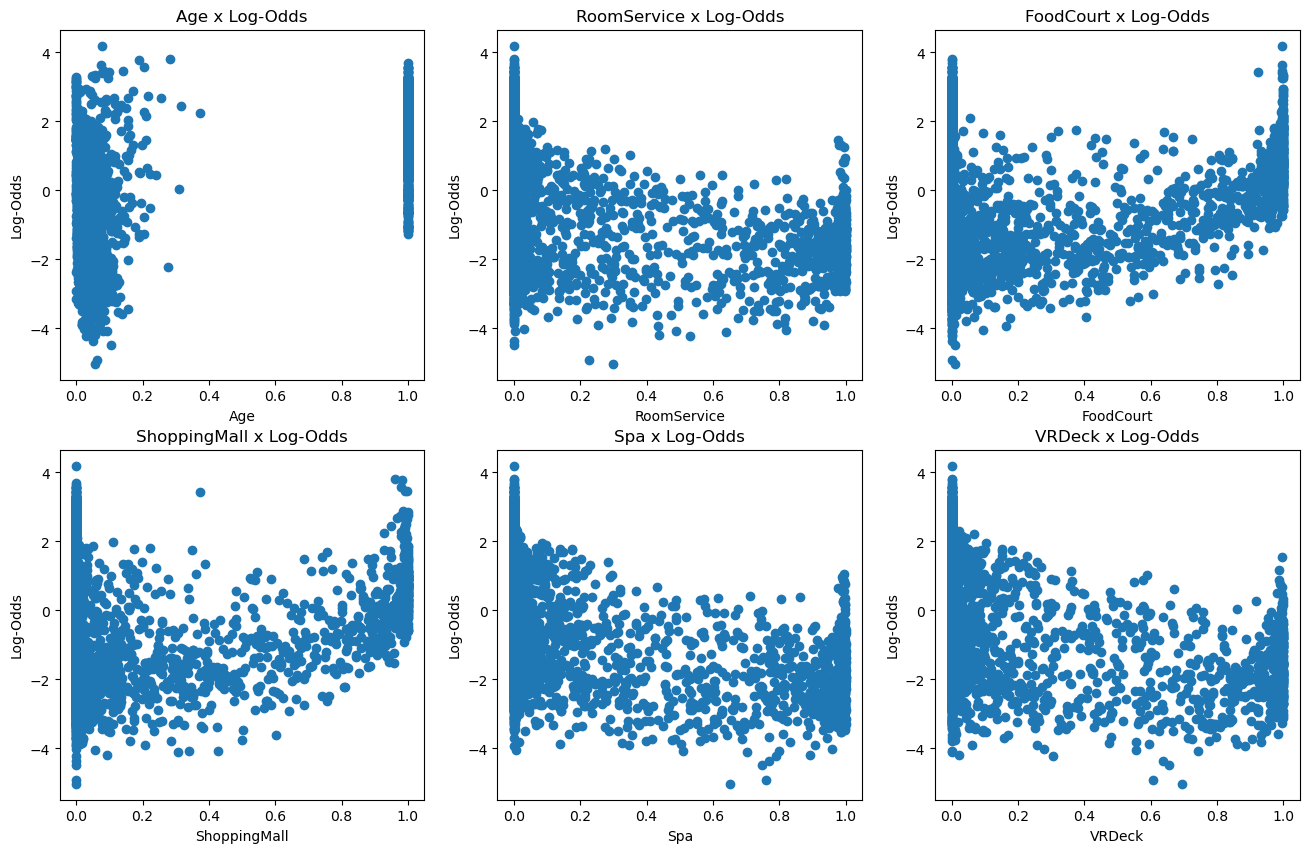

In [31]:
# Visualizing Log-Odds
fig, [ax1, ax2] = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(16)

ax1[0].scatter(x=test_data_transformed['Age'], y=log_odds_log_reg_predict_prob)
ax1[0].set_title('Age x Log-Odds')
ax1[0].set_ylabel('Log-Odds')
ax1[0].set_xlabel('Age')

ax1[1].scatter(x=test_data_transformed['RoomService'], y=log_odds_log_reg_predict_prob)
ax1[1].set_title('RoomService x Log-Odds')
ax1[1].set_ylabel('Log-Odds')
ax1[1].set_xlabel('RoomService')

ax1[2].scatter(x=test_data_transformed['FoodCourt'], y=log_odds_log_reg_predict_prob)
ax1[2].set_title('FoodCourt x Log-Odds')
ax1[2].set_ylabel('Log-Odds')
ax1[2].set_xlabel('FoodCourt')

ax2[0].scatter(x=test_data_transformed['ShoppingMall'], y=log_odds_log_reg_predict_prob)
ax2[0].set_title('ShoppingMall x Log-Odds')
ax2[0].set_ylabel('Log-Odds')
ax2[0].set_xlabel('ShoppingMall')

ax2[1].scatter(x=test_data_transformed['Spa'], y=log_odds_log_reg_predict_prob)
ax2[1].set_title('Spa x Log-Odds')
ax2[1].set_ylabel('Log-Odds')
ax2[1].set_xlabel('Spa')

ax2[2].scatter(x=test_data_transformed['VRDeck'], y=log_odds_log_reg_predict_prob)
ax2[2].set_title('VRDeck x Log-Odds')
ax2[2].set_ylabel('Log-Odds')
ax2[2].set_xlabel('VRDeck')

plt.show()

In [32]:
first_submission = submission_sample.copy()
first_submission['Transported'] = log_reg_predict
# first_submission.to_csv('../submissions/first_submission.csv', index=None)
first_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [33]:
first_submission['Transported'].value_counts()

True     2249
False    2028
Name: Transported, dtype: int64

#### Logistic Regression using SelectKBest columns

In [35]:
encoder = pd.get_dummies(cat_feat, drop_first=True)
scaler = Normalizer().fit_transform(num_feat)
scaler = pd.DataFrame(scaler, columns=num_feat.columns)

features = pd.concat([encoder, scaler], axis=1)
target = train_data['Transported']

##### Selecting KBest #####

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

classification_score = []
features_used = []

for i in np.arange(24):
    kbest_selector = SelectKBest(score_func=chi2, k=i+1)
    X_new_k = kbest_selector.fit_transform(X_train, y_train)
    feature_names_out = kbest_selector.get_feature_names_out()
    
    features_used.append(feature_names_out)
    
    log_reg = LogisticRegression()
    log_reg.fit(X_new_k, y_train)

    classification_score.append(log_reg.score(X_test[feature_names_out], y_test))

max_clf_ind = classification_score.index(max(classification_score))
features_used_to_max = features_used[max_clf_ind]

##### Predicting #####

num_feat_test = test_data.select_dtypes(np.number)
cat_feat_test = test_data.select_dtypes(np.object)

encoder_test = pd.get_dummies(cat_feat_test, drop_first=True)
scaler_test = Normalizer().fit_transform(num_feat_test)
scaler_test = pd.DataFrame(scaler_test, columns=num_feat_test.columns)

test_data_transformed = pd.concat([encoder_test, scaler_test], axis=1)
kbest_test_data_transformed = test_data_transformed[features_used_to_max]

kbest_features = features[features_used_to_max]

log_reg_2 = LogisticRegression()
log_reg_2.fit(kbest_features, target)

log_reg_2_predict = log_reg_2.predict(kbest_test_data_transformed)

# Testing assumptions of the model

log_reg_2_predict_prob = log_reg_2.predict_proba(kbest_features)[:,1] # probability of True
log_odds_log_reg_2_predict_prob = np.log(log_reg_predict_prob/(1-log_reg_predict_prob)) # log-odds

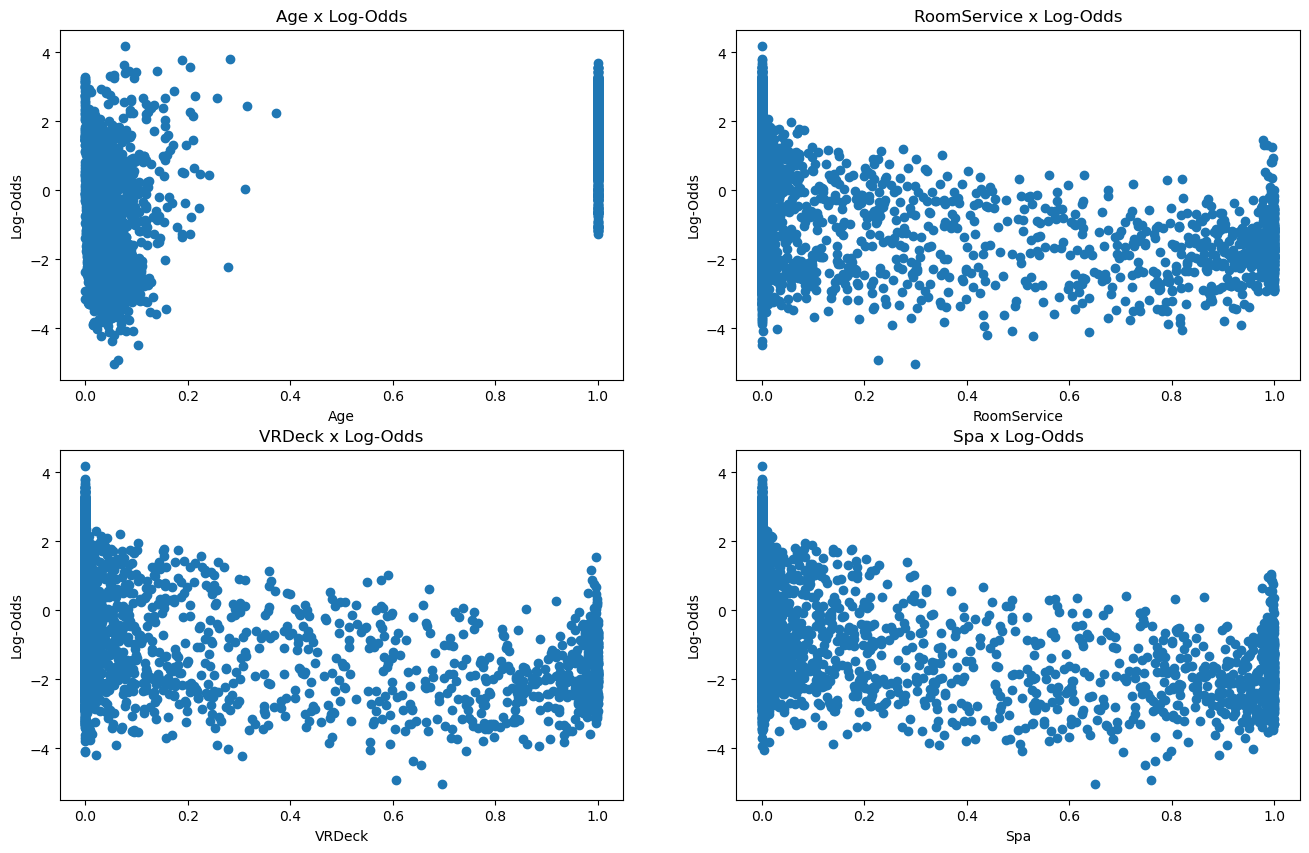

In [36]:
# Visualizing Log-Odds
fig, [ax1, ax2] = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(16)

ax1[0].scatter(x=kbest_test_data_transformed['Age'], y=log_odds_log_reg_2_predict_prob)
ax1[0].set_title('Age x Log-Odds')
ax1[0].set_ylabel('Log-Odds')
ax1[0].set_xlabel('Age')

ax1[1].scatter(x=kbest_test_data_transformed['RoomService'], y=log_odds_log_reg_2_predict_prob)
ax1[1].set_title('RoomService x Log-Odds')
ax1[1].set_ylabel('Log-Odds')
ax1[1].set_xlabel('RoomService')

ax2[0].scatter(x=kbest_test_data_transformed['VRDeck'], y=log_odds_log_reg_2_predict_prob)
ax2[0].set_title('VRDeck x Log-Odds')
ax2[0].set_ylabel('Log-Odds')
ax2[0].set_xlabel('VRDeck')

ax2[1].scatter(x=kbest_test_data_transformed['Spa'], y=log_odds_log_reg_2_predict_prob)
ax2[1].set_title('Spa x Log-Odds')
ax2[1].set_ylabel('Log-Odds')
ax2[1].set_xlabel('Spa')

plt.show()

In [37]:
second_submission = submission_sample.copy()
second_submission['Transported'] = log_reg_2_predict
# second_submission.to_csv('../submissions/second_submission.csv', index=None)
second_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [38]:
second_submission['Transported'].value_counts()

True     2248
False    2029
Name: Transported, dtype: int64

In [39]:
# 7.7 joblib

In [40]:
submission_sample

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False
